In [1]:
import gudhi
import wfdb 
from wfdb import processing
import numpy as np

import persistencecurves as pc

from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d

import scipy as scp

In [2]:
def quasi_attractorize(series, step):
    n = series.shape[0]

    z = []
    for i in range(n - step + 1):
        z.append(series[i:i + step].reshape(1, 3)[0])

    return np.array(z)

In [3]:
def plot_attractor(attractor):
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    ax.scatter(xs=attractor[:, 0],
            ys=attractor[:, 1],
            zs=attractor[:, 2])
    plt.title(f'{len(attractor)}')
    plt.show()

In [4]:
def extract_numpy_from_diag(diagram):
    tuples = [x[1] for x in diagram]
    xs = np.array([d[0] for d in tuples])
    ys = np.array([d[1] for d in tuples])

    return np.array([xs, ys]).T

In [158]:
wfdb.show_ann_labels()

label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13      Q  

In [62]:
beat_annotations = ['N', 'L', 'R', 'B', 'A', 'a', 'J', 'S', 'V', 'r', 'F', 'e', 'j', 'n', 'E', '/', 'f', 'Q', '?']

non_beat_annotations = ['[', '!', ']', 'x', '(', ')', 'p', 't', 'u', '`', "'", '^', '|', '~', 's', 'T', '*', 'D', '=', '"', '@']
ignore_annotations = ['Q', '?']

classes_mapping = {
    'N': 0,
    '/': 0,
    'f': 0,
    'F': 1,
    'L': 1,
    'R': 1,
    'B': 1,
    'A': 1,
    'a': 1, 
    'J': 1,
    'S': 1,
    'V': 1,
    'r': 1,
    'e': 1,
    'j': 1,
    'n': 1,
    'E': 1
}

In [63]:
def calculate_attractors(signal, annotations, event_indexes, step):
    n = event_indexes.shape[0]

    attractors = []
    attractor_annotations = []
    for i in range(n - step + 1):
        idx1 = event_indexes[i]
        idx2 = event_indexes[i+step-1] + 1 
        
        extracted_signal = signal[idx1:idx2]
        
        attractor = quasi_attractorize(extracted_signal, step=3)
        ann = annotations[i + int(step/2)]

        attractors.append(attractor)
        attractor_annotations.append(ann)

    return attractors, attractor_annotations

In [64]:
def filter_signal(signal, cutoff_freqs, fs, numtaps):
    filter_taps = scp.signal.firwin(numtaps=numtaps, fs=fs, cutoff=cutoff_freqs)
    return scp.signal.lfilter(filter_taps, 1.0, x=signal)

In [72]:
annotation = wfdb.rdann('../data/arrhythmia/100', 'atr')
record = wfdb.rdrecord('../data/arrhythmia/100')

In [66]:
def preprocess(record, annotation, new_fs, numtaps, cutoff_freqs):
    # Resampling to 200 Hz
    zero_channel_signal, resampled_ann = processing.resample_singlechan(record.p_signal[:, 0], annotation, record.fs, new_fs)

    # FIR filtering 
    # TODO how to choose numtaps???
    filtered = filter_signal(zero_channel_signal, cutoff_freqs, record.fs, numtaps)

    # Normalizing signal to 0, 1
    preprocessed_signal = processing.normalize_bound(filtered, lb=0, ub=1)

    return preprocessed_signal, resampled_ann

In [73]:
prep_signal, annotations = preprocess(record, annotation, new_fs=200, numtaps=21, cutoff_freqs=[0.5, 50])

In [75]:
# Comparing original and filtered signal
# original_resampled, resampled_ann = processing.resample_singlechan(record.p_signal[:, 0], annotation, record.fs, 200)
# original_scaled = processing.normalize_bound(original_resampled, lb=0, ub=1)

# ax = plt.figure(figsize=(50, 50))
# plt.plot(prep_signal)
# plt.plot(original_scaled)

# plt.legend(labels=['filtered', 'original'])

In [76]:
# Skip first event 
attractors, attractor_anns = calculate_attractors(prep_signal, annotations.symbol[1:], annotations.sample[1:], 3)

# TODO drop classes which are in the non_beat_annotations and ignore_annotations
classes = list(map(lambda x: classes_mapping[x], attractor_anns))

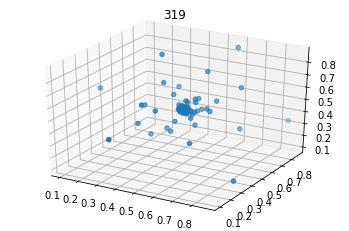

In [77]:
plot_attractor(attractors[1])

In [273]:
def get_gudhi_diagram(points, plot=False):
    gudhi_complex = gudhi.RipsComplex(points=points)
    # gudhi_complex = gudhi.AlphaComplex(points=signal)
    simplex_tree = gudhi_complex.create_simplex_tree(max_dimension=2)

    diag = simplex_tree.persistence()
    if plot:
        gudhi.plot_persistence_diagram(diag, legend=True)
    
    return diag

In [274]:
j = 0
for i in range(len(attractors)):
    if classes[i] == 1:
        print(i)
        j += 1
        get_gudhi_diagram(attractors[i])
    if j == 10:
        break

6
229
257
341
440
598
986
1077
1084
1102


In [275]:
def extract_numpy_from_diag(diagram):
    tuples = [x[1] for x in diagram]
    xs = np.array([d[0] for d in tuples])
    ys = np.array([d[1] for d in tuples])
    
    return np.array([xs, ys]).T

In [276]:
arrhythmias = [6, 229, 257, 341, 440, 598, 986, 1077, 1084, 1102]
diagrams = [extract_numpy_from_diag(get_gudhi_diagram(attractors[i])) for i in arrhythmias]

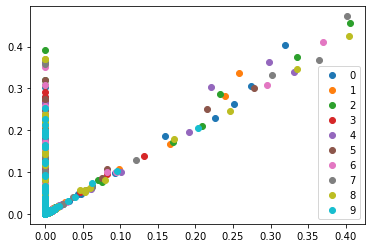

In [277]:
for d in diagrams:
    plt.scatter(x=d[:, 0], y=d[:, 1])
    plt.legend(labels=[i for i in range(len(diagrams))])

In [288]:
D_normal = pc.Diagram(Dgm=extract_numpy_from_diag(get_gudhi_diagram(attractors[2000])), 
               globalmaxdeath=None, 
               infinitedeath=float('inf'), 
               inf_policy="remove")

In [293]:
curves = []
for diag in diagrams:
    D = pc.Diagram(Dgm=diag, globalmaxdeath=None, infinitedeath=float('inf'), inf_policy="remove")
    curve = D.Betticurve(meshstart=0.05, meshstop=np.max(diag[:, 0]), num_in_mesh=100000)
    curves.append(curve)

In [294]:

normal_curve = D_normal.Betticurve(meshstart=0.05, meshstop=np.max(diag[:, 0]), num_in_mesh=100000)

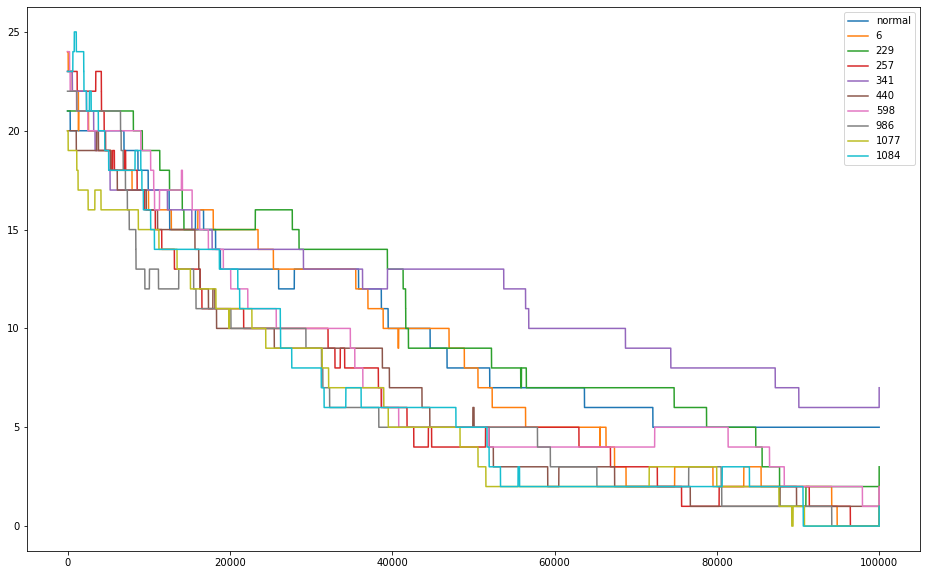

In [301]:
plt.figure(figsize=(16, 10))

plt.plot(normal_curve)
plt.plot(curves[0])
plt.plot(curves[1])
plt.plot(curves[2])
plt.plot(curves[3])
plt.plot(curves[4])
plt.plot(curves[5])
plt.plot(curves[6])
plt.plot(curves[7])
plt.plot(curves[8])

plt.legend(labels=['normal', 
                    f'{arrhythmias[0]}', 
                    f'{arrhythmias[1]}',
                    f'{arrhythmias[2]}',
                    f'{arrhythmias[3]}',
                    f'{arrhythmias[4]}',
                    f'{arrhythmias[5]}',
                    f'{arrhythmias[6]}',
                    f'{arrhythmias[7]}',
                    f'{arrhythmias[8]}'])